# Forecasting con NNets tradicionales - PyTorch

Los objetivos de este notebook son:
- Ilustrar como crear un `Dataset` de PyTorch que permita obtener `DataLoaders` que proporciones batches de datos basados en una serie de tiempo, dada una ventana histórica predictiva y una ventana futura a predecir.
- Ilustrar como implementar un modelo de red neuronal tradicional de regresión para pronosticar sobre los datos secuenciales

Al igual que en el notebook anterior, los datos que vamos a analizar son los correspondientes al número de pasajeros aéreos mensuales. Van desde enero de 1949 hasta diciembre de 1960.

In [1]:
import numpy as np
import pandas as pd
import os, random, time, copy
import matplotlib.pyplot as plt #gráficos
from math import sqrt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

Utilizamos la primera GPU disponible


device(type='cuda', index=0)

In [4]:
def reset_seed():
    SEED = 42
    torch.backends.cudnn.enabled = True
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## 1. Carga de datos originales

Cargamos los datos para entenderlos

In [5]:
df = pd.read_csv('01-02-AirPassengers.csv', sep=',', na_values=".")
print(df.shape)
df.head(5)

(144, 2)


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Vamos a modificar el nombre de las variables ("#Passengers" no nos permite acceder fácilmente a esa columna del dataframe).

In [6]:
df.columns = ['Mes', 'Pasajeros']

In [7]:
df.shape[0]

144

Tenemos 144 datos, correspondientes a los números de pasajeros mensuales en los últimos 12 años. Visualicemos los datos para buscar patrones.

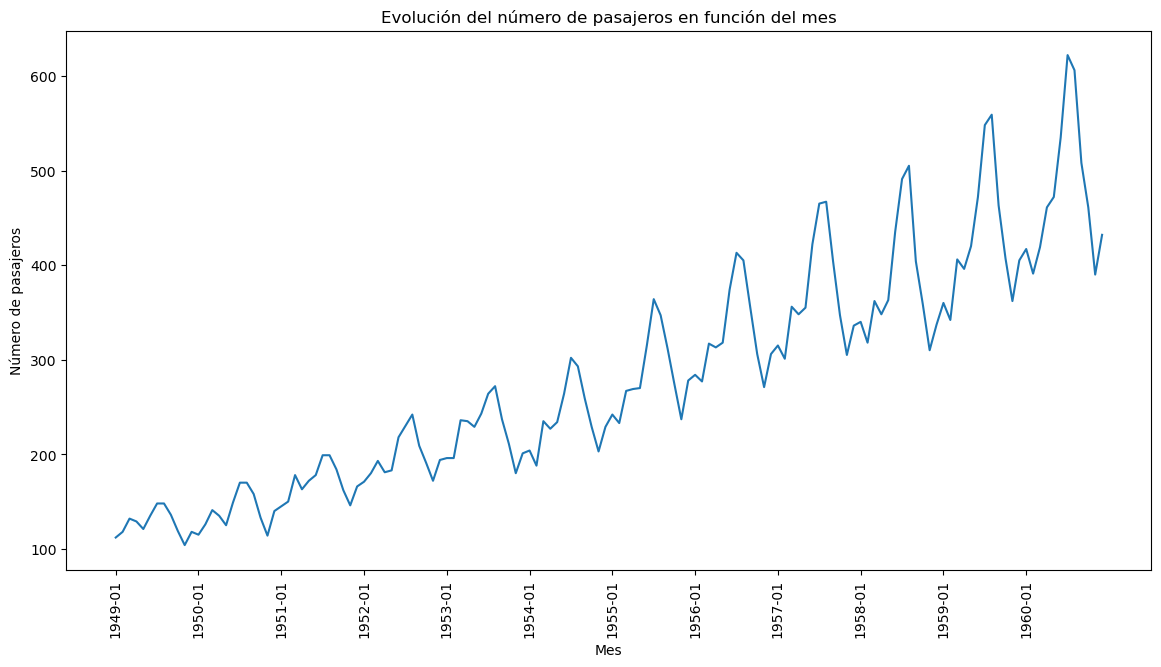

In [8]:
plt.figure(figsize=(14,7))
ax = plt.gca() # get current axis
plt.plot(df.Mes, df.Pasajeros)
plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Evolución del número de pasajeros en función del mes')
plt.xticks(np.arange(0,144,12), rotation=90)
plt.show()

Nos salta a la vista la estacionalidad de los datos y la tendencia creciente.

## 2. Preparación de los datos

Tenemos unos datos representados por una serie de tiempo univariada en una instancia de `DataFrame` de pandas.
PyTorch dispone de su propia estructura de conjuntos de datos con la clase `Dataset`, que proporciona una manera estandarizada de manejar y abstraer los datos. Su propósito es definir cómo se acceden y procesan los datos, facilitando su reutilización y personalización, proporcionando:
- Acceso ordenado a los datos: Organiza los datos en un formato indexado, como un arreglo, para que sea fácil recuperarlos durante el entrenamiento o inferencia.
- Carga personalizada de datos: Permite implementar cualquier preprocesamiento o transformación necesario (como normalización, redimensionado, etc.).
- Flexibilidad: Puedes cargar datos desde diferentes fuentes (archivos CSV, imágenes, bases de datos, etc.) mediante la implementación de un Dataset personalizado.

Para implementar una clase que herede de `torch.utils.data.Dataset`, es necesario sobrescribir los métodos:
- `__init__`: método constructor donde se instancian las estructuras internas para el almacenamiento y procesamiento de datos.
- `__len__`: Para devolver el número total de muestras.
- `__getitem__`: Para obtener una muestra específica (entrada y etiqueta).


Definimos entonces la clase `SerieTiempoSenoDataset`, que hereda de `Dataset` y que recibe como parámetros:
- `values`: instancia de `np.array` con los valores numéricos de la serie de tiempo
- `time_index` (opcional): instancia de `np.array` con los índices temporales asociados a cada valor; si presente, debe tener el mismo largo de `values`.
- `past_window`: número de pasos de tiempo históricos a considerar como predictores. Por defecto es 12.
- `lag_future_lag`: número de pasos de tiempo de diferencia entre el final de una ventana histórica y el valor a predecir. Por defecto es 0 (se predice el valor inmediatamente posterior).


In [17]:
class SerieDeTiempoUnivariadaDataset(Dataset):
    def __init__(self, values, time_index=None, past_window=12, future_lag=0):
        if past_window <= 0:
            raise ValueError("La ventana de tiempo histórica debe tener al menos un dato")
        if future_lag < 0:
            raise ValueError("El lag del valor futuro a predecir no puede ser negativo")
        if time_index is None:
            self.time_index = np.range(len(values))
        else:
            self.time_index = time_index

        self.values = values.astype(np.float32)
        if len(self.time_index) != len(self.values):
            raise ValueError("Los valores y sus índices tienen largos diferentes")
                                       
        self.past_window = past_window
        self.future_lag = future_lag
        
    def __len__(self):
        return len(self.values)-self.past_window-self.future_lag

    def __getitem__(self, idx):
        if (idx > len(self)) or (idx < 0):
            raise Exception("Out of bounds: idx=", idx)
        return self.values[idx: idx+past_window], self.values[idx+self.past_window+self.future_lag]
        
        # return torch.reshape(self.y[idx: idx+self.ventanaPasado], (self.ventanaPasado, 1)),\
        #     self.y[idx+self.ventanaPasado: idx+self.ventanaPasado+self.ventanaFuturo]

In [18]:
periodos_train = 120
past_window=12

In [20]:
train_data = SerieDeTiempoUnivariadaDataset(values=np.array(df.Pasajeros)[:periodos_train+past_window], 
                                            time_index=np.array(df.Mes)[:periodos_train+past_window], 
                                            past_window=past_window, future_lag=0)

In [21]:
np.array(df.Pasajeros)[:periodos_train]

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467,
       404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404,
       359, 310, 337], dtype=int64)

In [22]:
np.array(df.Pasajeros)[:periodos_train+12]

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467,
       404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404,
       359, 310, 337, 360, 342, 406, 396, 420, 472, 548, 559, 463, 407,
       362, 405], dtype=int64)

In [23]:
len(train_data)

120

In [24]:
train_data[0]

(array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
        118.], dtype=float32),
 115.0)

In [26]:
train_data[119]

(array([337., 360., 342., 406., 396., 420., 472., 548., 559., 463., 407.,
        362.], dtype=float32),
 405.0)

In [31]:
test_data = SerieDeTiempoUnivariadaDataset(values=np.array(df.Pasajeros)[periodos_train:],
                                           time_index=np.array(df.Mes)[periodos_train:], 
                                            past_window=past_window, future_lag=0)

In [32]:
np.array(df.Pasajeros)[periodos_train:]

array([360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405, 417,
       391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432], dtype=int64)

In [33]:
len(test_data)

12

In [34]:
test_data.values

array([360., 342., 406., 396., 420., 472., 548., 559., 463., 407., 362.,
       405., 417., 391., 419., 461., 472., 535., 622., 606., 508., 461.,
       390., 432.], dtype=float32)

In [35]:
test_data[0]

(array([360., 342., 406., 396., 420., 472., 548., 559., 463., 407., 362.,
        405.], dtype=float32),
 417.0)

In [36]:
test_data[11]

(array([405., 417., 391., 419., 461., 472., 535., 622., 606., 508., 461.,
        390.], dtype=float32),
 432.0)

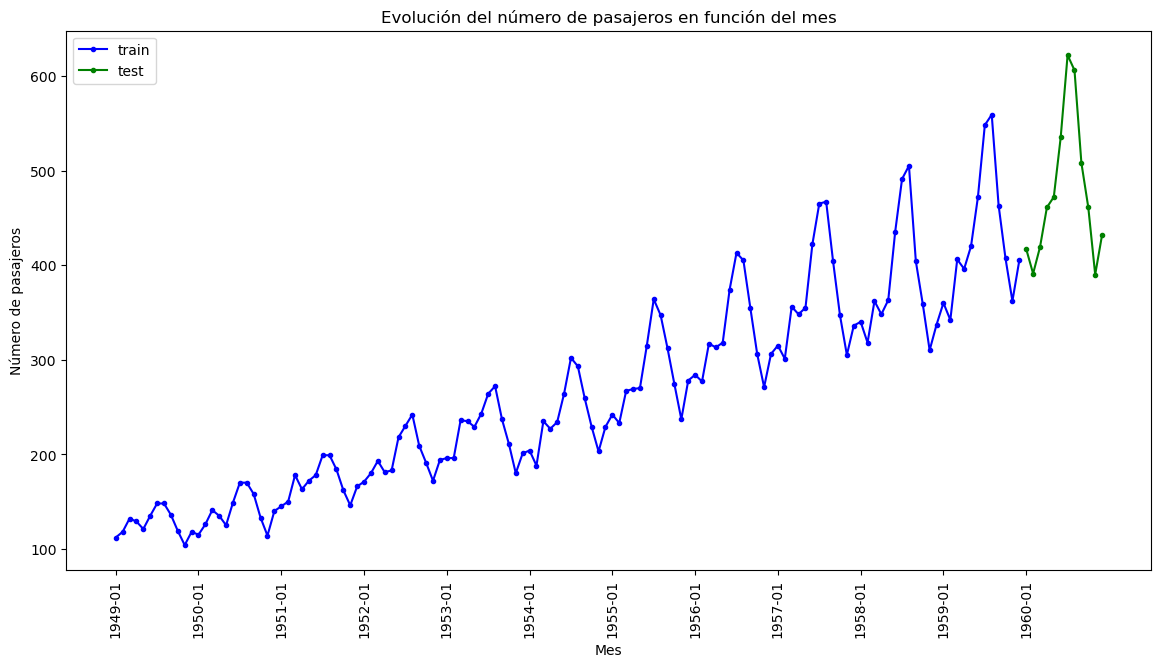

In [43]:
plt.figure(figsize=(14,7))
ax = plt.gca() # get current axis
plt.plot(train_data.time_index, train_data.values, color = 'blue', marker = ".", label='train')
plt.plot(test_data.time_index[past_window:], test_data.values[past_window:], color = 'green', marker = ".", label='test')
plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Evolución del número de pasajeros en función del mes')
plt.xticks(np.arange(0,144,12), rotation=90)
plt.legend(loc='upper left')
plt.show()

Ahora que tenemos el dataset creado, vamos ahora a crear un `DataLoader`. Esta clase actúa como un intermediario entre el `Dataset` y el modelo, proporcionando batched de datos de manera eficiente. Proporciona:
- Particionamiento de datos en Mini-batches: Divide los datos en lotes más pequeños (batches) para acelerar el entrenamiento (especialmente en GPU).
- Barajado de datos (`shuffle`): Permite mezclar los datos en cada época para evitar patrones y garantizar un entrenamiento robusto.
- Paralelismo: Utiliza múltiples hilos para cargar datos (`num_workers`), acelerando el proceso de entrenamiento.
- Iteración simplificada: Proporciona una interfaz iterable para recorrer los datos en cada época.

El `DataLoader` de entrenamiento lo barajamos con `shuffle=True`, para no introducir sesgos de orden de presentación de instancias de aprendizale; el de test no requiere de ese tratamiento.

In [44]:
train_dataloader = DataLoader(train_data, batch_size=6, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=6, shuffle=False)

Analicemos como sería la creación de un batch con los `DataLoader`.

In [45]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Train: Feature batch shape: {train_features.size()}")
print(f"Train: Labels batch shape: {train_labels.size()}")
test_features, test_labels = next(iter(test_dataloader))
print(f"Test: Feature batch shape: {test_features.size()}")
print(f"Test: Labels batch shape: {test_labels.size()}")

Train: Feature batch shape: torch.Size([6, 12])
Train: Labels batch shape: torch.Size([6])
Test: Feature batch shape: torch.Size([6, 12])
Test: Labels batch shape: torch.Size([6])


In [46]:
train_features[0]

tensor([278., 284., 277., 317., 313., 318., 374., 413., 405., 355., 306., 271.])

In [47]:
train_labels[0]

tensor(306.)

## 3. Modelamiento y evaluación

Vamos a crear un modelo sencillo en PyTorch, con capas densas.
Por simplicidad del problema, nos limitaremos a una única capa escondida

In [68]:
class ForecastingUnivariadoRegresion(nn.Module):
    def __init__(self, num_features, num_hidden):
        super(ForecastingUnivariadoRegresion, self).__init__()    
        self.fc1 = nn.Linear(in_features=num_features, out_features=num_hidden)
        self.fc2 = nn.Linear(in_features=num_hidden, out_features=num_hidden)
        self.fc3 = nn.Linear(in_features=num_hidden, out_features=num_hidden)
        self.fc4 = nn.Linear(in_features=num_hidden, out_features=1)
        self._reset_params()

    def forward(self, past_window):
        x = self.fc1(past_window)
        x = F.relu(x)
        # x = self.fc2(x)
        # x = F.relu(x)
        # x = self.fc3(x)
        # x = F.relu(x)
        pred = self.fc4(x)
        return pred

    def _reset_params(self):
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)

In [99]:
reset_seed()
modelo = ForecastingUnivariadoRegresion(num_features=past_window, num_hidden=50)
print(modelo)

for name, param in modelo.named_parameters():
    print(f"Param: {name} | Size: {param.size()} | Values : {param[:2]} \n")

ForecastingUnivariadoRegresion(
  (fc1): Linear(in_features=12, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=1, bias=True)
)
Param: fc1.weight | Size: torch.Size([50, 12]) | Values : tensor([[ 0.2833,  0.2986, -0.1882, -0.3092, -0.2175,  0.0876,  0.1249,  0.1634,
          0.1351,  0.3026, -0.2359, -0.2439],
        [-0.0974,  0.2415, -0.2389,  0.2332,  0.0518,  0.1924,  0.3082,  0.3028,
          0.2986, -0.0763, -0.1327,  0.1321]], grad_fn=<SliceBackward0>) 

Param: fc1.bias | Size: torch.Size([50]) | Values : tensor([-0.1556,  0.1509], grad_fn=<SliceBackward0>) 

Param: fc2.weight | Size: torch.Size([50, 50]) | Values : tensor([[-0.1514,  0.1479, -0.0902,  0.0632,  0.0144,  0.1749, -0.0547, -0.0995,
         -0.0488,  0.0022, -0.1156,  0.1684, -0.1313,  0.0387, -0.1881, -0.0304,
         -0.0528, -0.0980,  0.1280, -0.2187,  0.0257, -0.02

Ahora podemos aplicar el modelo a un batch de entrenamiento (aunque todavía está con los parámetros iniciales sin entrenar).

In [100]:
train_features

tensor([[278., 284., 277., 317., 313., 318., 374., 413., 405., 355., 306., 271.],
        [347., 305., 336., 340., 318., 362., 348., 363., 435., 491., 505., 404.],
        [313., 318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.],
        [301., 356., 348., 355., 422., 465., 467., 404., 347., 305., 336., 340.],
        [119., 104., 118., 115., 126., 141., 135., 125., 149., 170., 170., 158.],
        [135., 148., 148., 136., 119., 104., 118., 115., 126., 141., 135., 125.]])

In [101]:
preds = modelo(train_features)

In [102]:
preds

tensor([[ -10.3473],
        [-107.4033],
        [ -73.2922],
        [   5.8158],
        [ -39.7806],
        [ -28.0614]], grad_fn=<AddmmBackward0>)

Vamos a entrenar el modelo. Creamos el método `train`.

In [103]:
def train_model(train_batch_size=6, fc1_n=10, learning_rate = 1e-3, epocas=30, val_split=0, early_stopping_loss_val_patience=-1, device="cpu", verbose=False):
    """Se encarga de realizar el ciclo de épocas de entrenamiento 

    :train_batch_size:
        tamaño del batch size de entrenamiento
    :fc1_n:
        número de neuronas de la capa escondida
    :learning_rate:
        learning rate del optimizador.
    :epocas:
        número de iteraciones de entrenamiento sobre el dataset completo
    :val_split:
        porcentaje del dataset de entrenamiento dedicado a la validación, su valor será limitado al intervalo [0 (sin validación), 0.5]
    :early_stopping_loss_val_patience:
        número de épocas de paciencia a esperar una mejora del val loss antes de suspender el entrenamiento. -1 implica que no se aplica
    :device:
        indica el dispositivo de procesamiento (cpu o cuda) sobre el cual se 
        va a realizar el entrenamiento
    :verbose:
        indica si se quiere imprimri el avance del proceso o no
    :returns:
        el modelo entrenado y los arrays con los valores de losses del training y validation setsdataset y el tiempo que tomó entrenar el modelo
    """
    start_time = time.time()
    reset_seed()

    # Gestión de los loaders de training y validation
    if val_split > 0.5:
        val_split=0.5

    if val_split < 0:
        val_split=0

    if val_split > 0:
        num_training_instances = int(len(train_data)*(1-val_split))
        num_validation_instances = len(train_data) - num_training_instances
        print(f"val_split: {val_split}, num_training_instances {num_training_instances}, num_validation_instances {num_validation_instances}")
        training_subset, validation_subset = torch.utils.data.random_split(
            train_data, [num_training_instances, num_validation_instances])
    
        train_loader = torch.utils.data.DataLoader(
            training_subset, batch_size=train_batch_size, shuffle=True)
        validation_loader = torch.utils.data.DataLoader(
            validation_subset, batch_size=6)
        
    else : 
        train_loader = torch.utils.data.DataLoader(
            train_data, batch_size=train_batch_size, shuffle=True)

    # Se crea el modelo y optimizador
    modelo = ForecastingUnivariadoRegresion(num_features=12, num_hidden=fc1_n)
    modelo = modelo.to(device) # situar el modelo en el dispositivo de procesamiento
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)

    # Creamos vectores donde almacenaremos los losses despuúes de cada época
    train_losses = [0] * epocas
    val_losses = [0] * epocas

    # variables a utilizar para el early stopping
    min_loss = np.Inf
    best_model = None
    num_epocas_patience = 0

    for epoca in range(epocas):
        epoca_start_time = time.time()
        for batch_features, batch_labels in train_loader:
            # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            # Generar las predicciones
            batch_preds = modelo(batch_features)
            # Comparar con las realidades a partir del loss function
            loss = loss_fn(batch_preds, batch_labels)
            # Calcular los gradientes de la función de pérdida
            loss.backward()
            # Actualizar parámetros con los gradientes
            optimizer.step()
            # Resetear los gradientes para no reacumularlos
            optimizer.zero_grad()
            # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
            train_losses[epoca] += loss.item() * batch_labels.size(0)

        # se normalizan el loss y el accuracy del training set
        train_losses[epoca] /= len(train_loader.dataset)

        if val_split > 0:
            # se desactiva la diferenciación automática para la inferencia sobre el val set
            modelo.eval()
            with torch.no_grad():
                for batch_features, batch_labels in validation_loader:
                    # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
                    batch_features = batch_features.to(DEVICE)
                    batch_labels = batch_labels.to(DEVICE)
                    # Generar las predicciones
                    batch_preds = modelo(batch_features)
                    # Comparar con las realidades a partir del loss function
                    loss = loss_fn(batch_preds, batch_labels)
                    # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
                    val_losses[epoca] += loss.item() * batch_labels.size(0)
            # se normalizan el loss y el accuracy del val set
            val_losses[epoca] /= len(validation_loader.dataset)
       
        epoca_end_time = time.time()
        segundos = epoca_end_time - epoca_start_time

        if verbose:
            if val_split > 0:
                print(f"{epoca}:  loss: {train_losses[epoca]:>7f}, val loss: {val_losses[epoca]:>7f}",
                      f"-- epoch time: {segundos:.2f}")
                
                # model checkpoint
                if val_losses[epoca] < min_loss:
                    best_model=copy.deepcopy(modelo)
                    print(f"Se mejoró el loss de {min_loss} a {val_losses[epoca]}")
                    min_loss = val_losses[epoca]
                    num_epocas_patience = 0
                else: 
                    num_epocas_patience +=1

                if early_stopping_loss_val_patience >-1 and num_epocas_patience > early_stopping_loss_val_patience:
                    print(f"----- Se sobrepasó el patience del val loss del early stopping {num_epocas_patience})")
                    break

            else:
                print(f"{epoca}:  loss: {train_losses[epoca]:>7f}",
                      f"-- epoch time: {segundos:.2f}")

                # model checkpoint
                if train_losses[epoca] < min_loss:
                    print(f"Se mejoró el val loss de {min_loss} a {train_losses[epoca]}")
                    min_loss = train_losses[epoca]

    end_time = time.time()
    if val_split > 0:     
        return best_model, train_losses, val_losses, (end_time-start_time)
    else:
        return modelo, train_losses, (end_time-start_time)

In [118]:
lr = 5e-4

In [119]:
modelo, train_losses, val_losses, tiempo = train_model(
    train_batch_size=6, fc1_n=10, learning_rate=lr, epocas=80, val_split=0.3, early_stopping_loss_val_patience=5, device=DEVICE, verbose=True)
print(f"Tiempo de entrenamiento {tiempo:.2f} segundos")

val_split: 0.3, num_training_instances 84, num_validation_instances 36
0:  loss: 103826.340681, val loss: 75617.504883 -- epoch time: 0.05
Se mejoró el loss de inf a 75617.5048828125
1:  loss: 73928.187500, val loss: 51677.697266 -- epoch time: 0.05
Se mejoró el loss de 75617.5048828125 a 51677.697265625
2:  loss: 50617.179688, val loss: 32243.141927 -- epoch time: 0.04
Se mejoró el loss de 51677.697265625 a 32243.141927083332
3:  loss: 34793.657366, val loss: 20584.433919 -- epoch time: 0.04
Se mejoró el loss de 32243.141927083332 a 20584.433919270832
4:  loss: 23602.802316, val loss: 14661.645020 -- epoch time: 0.05
Se mejoró el loss de 20584.433919270832 a 14661.64501953125
5:  loss: 19245.374163, val loss: 12027.822713 -- epoch time: 0.04
Se mejoró el loss de 14661.64501953125 a 12027.822713216146
6:  loss: 17625.796143, val loss: 10999.409953 -- epoch time: 0.04
Se mejoró el loss de 12027.822713216146 a 10999.409952799479
7:  loss: 17769.409912, val loss: 10656.950439 -- epoch tim

In [120]:
def plot_losses_and_accuracies(train_losses, val_losses=None):
    fig = plt.figure(figsize=(15,5))

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_losses)
    if val_losses is not None:
        ax.plot(val_losses)
        plt.legend(['train', 'val'], loc='upper left')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')

    _=plt.show()


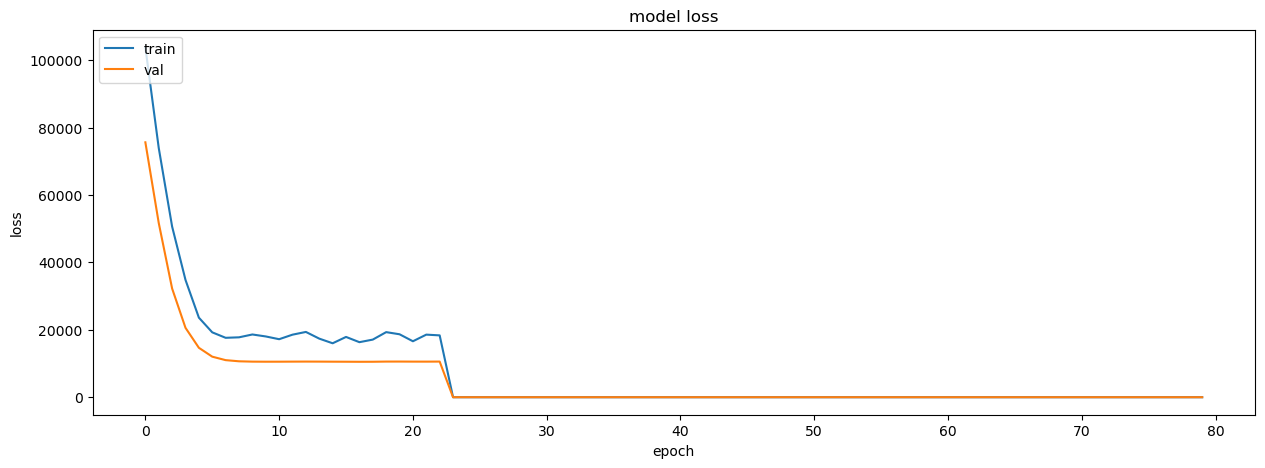

In [121]:
plot_losses_and_accuracies(train_losses, val_losses)

Se reentrena con todo el training set

In [122]:
modelo, train_losses, tiempo = train_model(
    train_batch_size=6, fc1_n=10, learning_rate=lr, epocas=80,  device=DEVICE, verbose=True)
print(f"Tiempo de entrenamiento {tiempo:.2f} segundos")

0:  loss: 98263.842773 -- epoch time: 0.08
Se mejoró el val loss de inf a 98263.8427734375
1:  loss: 78084.676562 -- epoch time: 0.05
Se mejoró el val loss de 98263.8427734375 a 78084.6765625
2:  loss: 60077.400684 -- epoch time: 0.04
Se mejoró el val loss de 78084.6765625 a 60077.40068359375
3:  loss: 43296.033887 -- epoch time: 0.04
Se mejoró el val loss de 60077.40068359375 a 43296.03388671875
4:  loss: 27531.121826 -- epoch time: 0.05
Se mejoró el val loss de 43296.03388671875 a 27531.121826171875
5:  loss: 21886.808252 -- epoch time: 0.05
Se mejoró el val loss de 27531.121826171875 a 21886.808251953124
6:  loss: 17959.433594 -- epoch time: 0.05
Se mejoró el val loss de 21886.808251953124 a 17959.43359375
7:  loss: 17493.015015 -- epoch time: 0.04
Se mejoró el val loss de 17959.43359375 a 17493.015014648438
8:  loss: 17876.348145 -- epoch time: 0.03
9:  loss: 18244.212305 -- epoch time: 0.04
10:  loss: 19095.362842 -- epoch time: 0.04
11:  loss: 16735.966663 -- epoch time: 0.04
Se 

Ahora que ya tenemos un modelo entrenado, vamos a pronosticar sobre el dataloader de test

In [123]:
def eval_model(modelo, dataloader, loss_fn=nn.MSELoss()):
    modelo.eval()
    loss = 0
    accuracy = 0

    with torch.no_grad():
        for batch_idx, (batch_features, batch_labels) in enumerate(dataloader):
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            batch_preds = modelo(batch_features)
            loss += loss_fn(batch_preds, batch_labels).item() * batch_labels.size(0)
            
    # se normalizan el loss y el accuracy del val set
    loss /= len(dataloader.dataset)

    return loss

In [124]:
test_loss = eval_model(modelo, test_dataloader)
print(f"El loss de test es {test_loss}")
print(f"El RMSE es {sqrt(test_loss)}")

El loss de test es 8782.732666015625
El RMSE es 93.71623480494522


In [125]:
def forecasting(modelo, dataloader):
    modelo.eval()
    preds = []

    with torch.no_grad():
        for batch_idx, (batch_features, batch_labels) in enumerate(dataloader):
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            batch_preds = modelo(batch_features)
            preds.extend(batch_preds.to("cpu").numpy().ravel().tolist())            
    return preds

In [126]:
test_preds = forecasting(modelo, test_dataloader)
test_preds

[409.6251525878906,
 414.4056396484375,
 462.3631896972656,
 496.1782531738281,
 490.9590148925781,
 432.095458984375,
 448.6406555175781,
 439.7529602050781,
 407.7789306640625,
 394.17205810546875,
 403.30047607421875,
 452.9002685546875]

In [127]:
meses_train = train_data.time_index
meses_test = test_data.time_index

In [128]:
meses_test

array(['1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
       '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
       '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
       '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
      dtype=object)

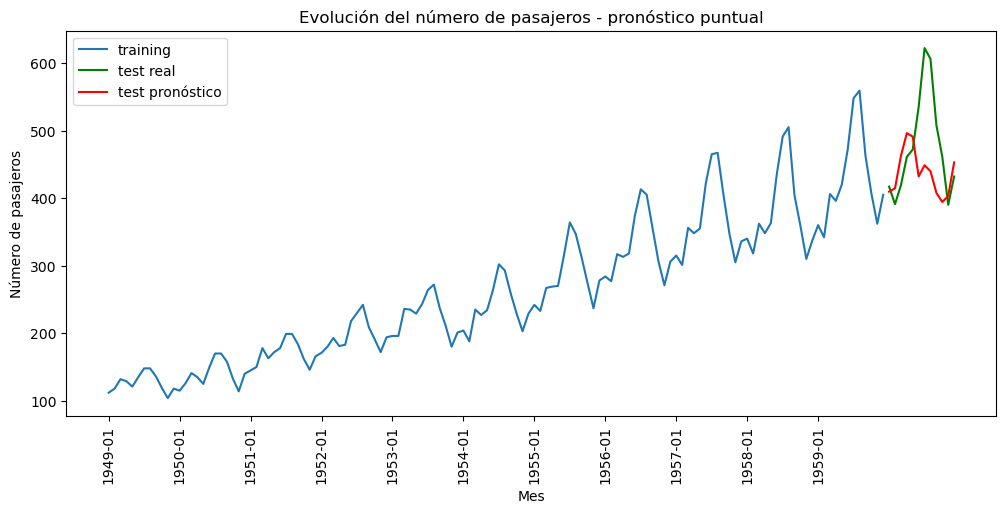

In [129]:
plt.figure(figsize=(12,5))
ax = plt.gca() # get current axis
plt.plot(meses_train, train_data.values, label="training")
plt.plot(meses_test[past_window:], test_data.values[past_window:], c="g", label="test real")
plt.plot(meses_test[past_window:], test_preds, c="r", label="test pronóstico")
plt.xlabel('Mes')
plt.ylabel('Número de pasajeros')
plt.title('Evolución del número de pasajeros - pronóstico puntual')
plt.legend()
plt.xticks(np.arange(0,132,12), rotation=90)
plt.show()